In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

# Load the dataset
file_path = 'data/train.csv'
data = pd.read_csv(file_path)

# Convert 'id' column to datetime format and set as index for time series analysis
data['id'] = pd.to_datetime(data['id'], errors='coerce', format='%Y-%m-%d %H')
data.set_index('id', inplace=True)

# Check dataset information and missing values
print("Dataset Information:\n")
data.info()
missing_values = data.isnull().sum()
print("\nMissing Values:\n", missing_values)

/Users/abohane/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Dataset Information:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40991 entries, 2020-01-01 00:00:00 to 2024-09-03 22:00:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   valeur_NO2   37694 non-null  float64
 1   valeur_CO    28462 non-null  float64
 2   valeur_O3    40298 non-null  float64
 3   valeur_PM10  33824 non-null  float64
 4   valeur_PM25  39200 non-null  float64
dtypes: float64(5)
memory usage: 1.9 MB

Missing Values:
 valeur_NO2      3297
valeur_CO      12529
valeur_O3        693
valeur_PM10     7167
valeur_PM25     1791
dtype: int64


In [2]:
# Basic Statistics for Each Pollutant
print("\nBasic Statistics:\n")
print(data.describe())


Basic Statistics:

         valeur_NO2     valeur_CO     valeur_O3   valeur_PM10   valeur_PM25
count  37694.000000  28462.000000  40298.000000  33824.000000  39200.000000
mean      21.831528      0.200710     50.574349     18.221523     11.051161
std       14.658381      0.103691     26.488626     11.282385      8.151742
min        1.100000      0.037000     -1.900000      0.500000      0.000000
25%       11.300000      0.145000     33.000000     10.700000      5.800000
50%       17.600000      0.177000     50.700000     15.600000      8.700000
75%       28.200000      0.226000     66.600000     22.900000     13.600000
max      131.000000      4.309000    193.100000    128.500000    111.100000


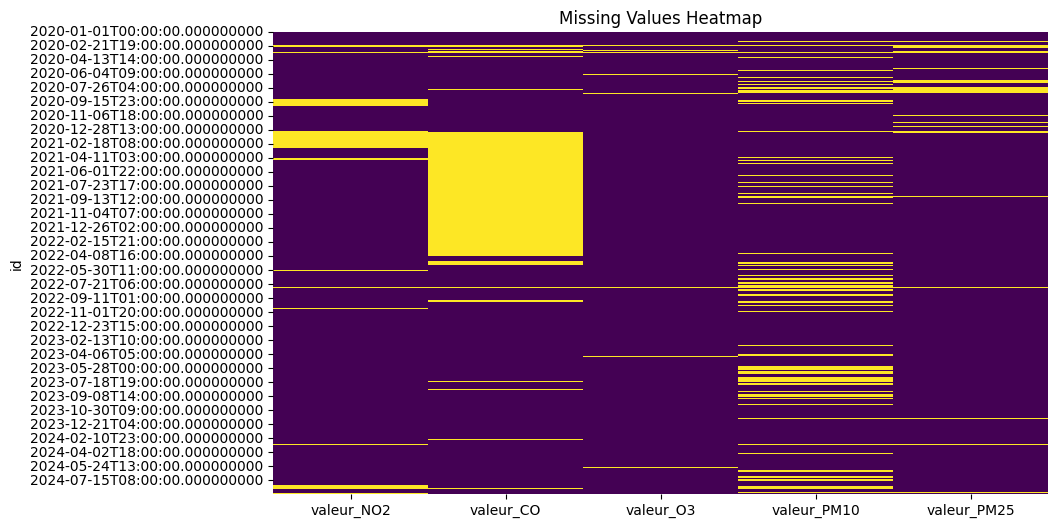

In [3]:
# Visualize Missing Data
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [4]:
# Apply interpolation for small gaps
data.interpolate(method='linear', limit_direction='both', inplace=True)

# Fill larger gaps using rolling mean for pollutants
pollutants = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']
for pollutant in pollutants:
    # Rolling fill for larger gaps
    data[pollutant] = data[pollutant].fillna(data[pollutant].rolling(window=24, min_periods=1).mean())

# Remaining missing values, if any, are forward/backward filled
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

# Verify no missing values remain
print("Missing values after QOLmat-inspired filling:\n", data.isnull().sum())

Missing values after QOLmat-inspired filling:
 valeur_NO2     0
valeur_CO      0
valeur_O3      0
valeur_PM10    0
valeur_PM25    0
dtype: int64


/var/folders/61/n2sfq6s16zdgx5_xwt6gtdvr0000gn/T/ipykernel_13231/1403290186.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/var/folders/61/n2sfq6s16zdgx5_xwt6gtdvr0000gn/T/ipykernel_13231/1403290186.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


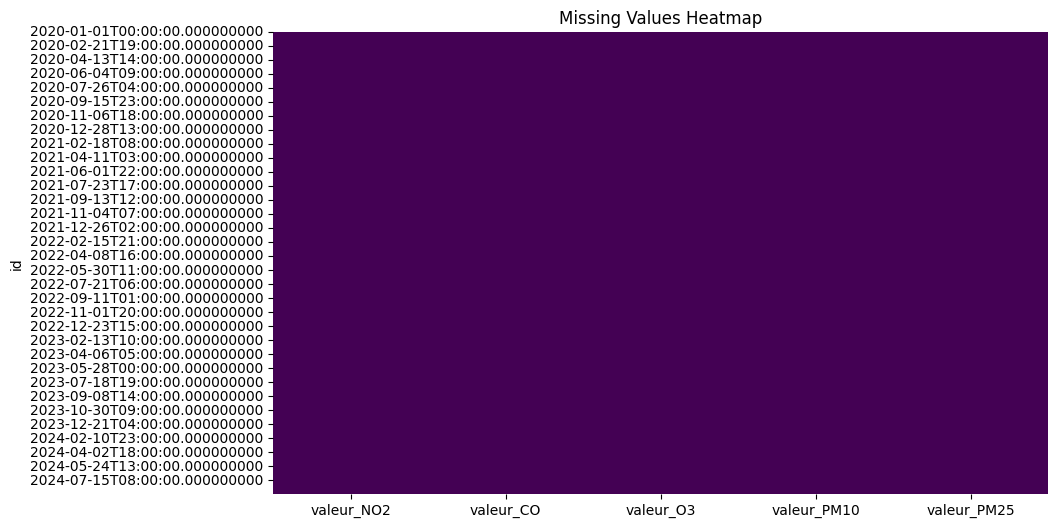

In [5]:
# Visualize Missing Data
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

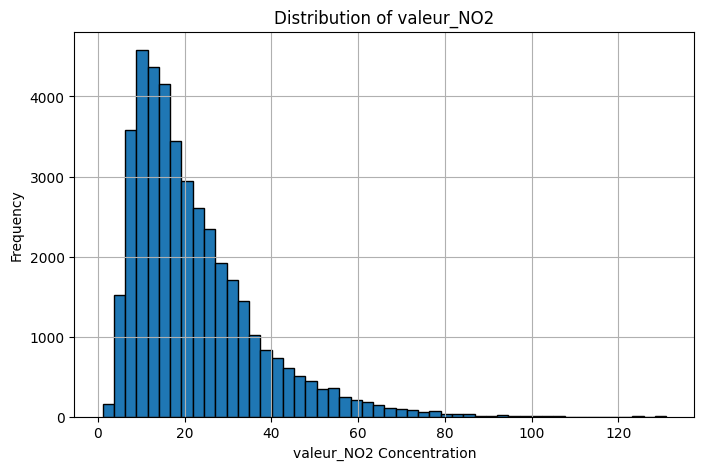

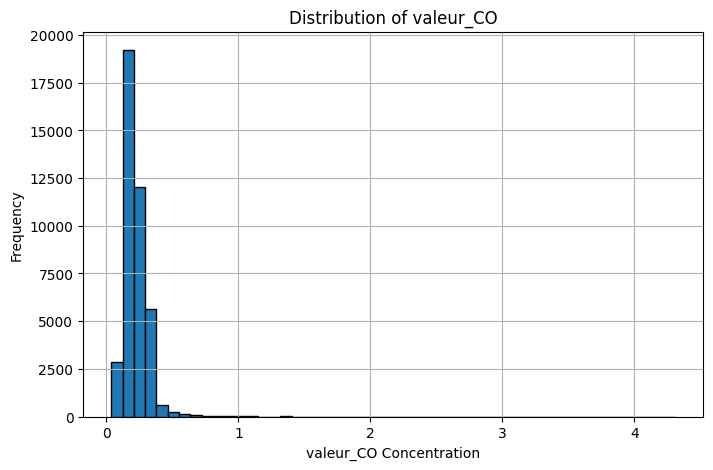

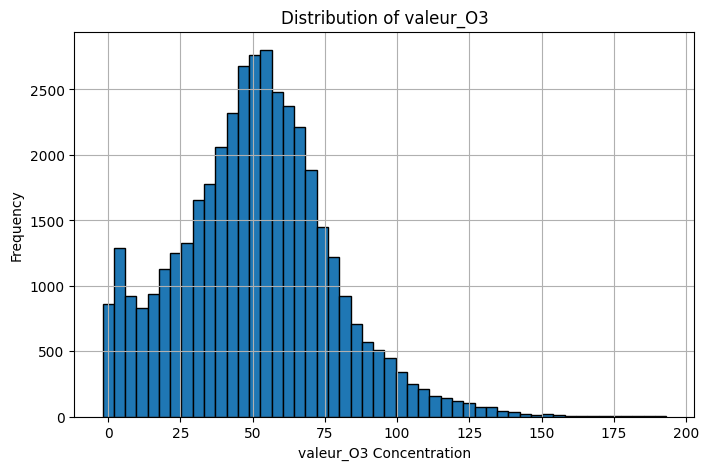

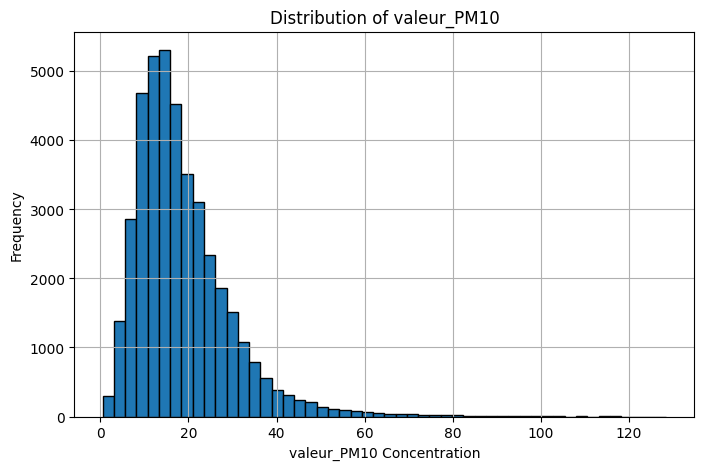

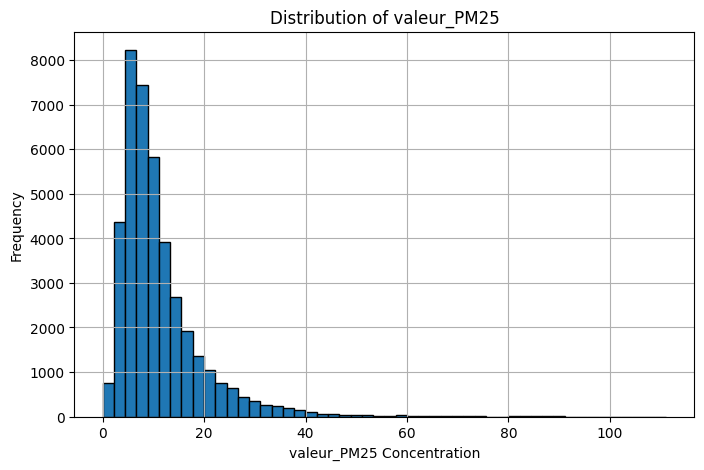

In [6]:
# Plot distributions for each pollutant
pollutants = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']
for pollutant in pollutants:
    plt.figure(figsize=(8, 5))
    data[pollutant].dropna().hist(bins=50, edgecolor='black')
    plt.title(f'Distribution of {pollutant}')
    plt.xlabel(f'{pollutant} Concentration')
    plt.ylabel('Frequency')
    plt.show()

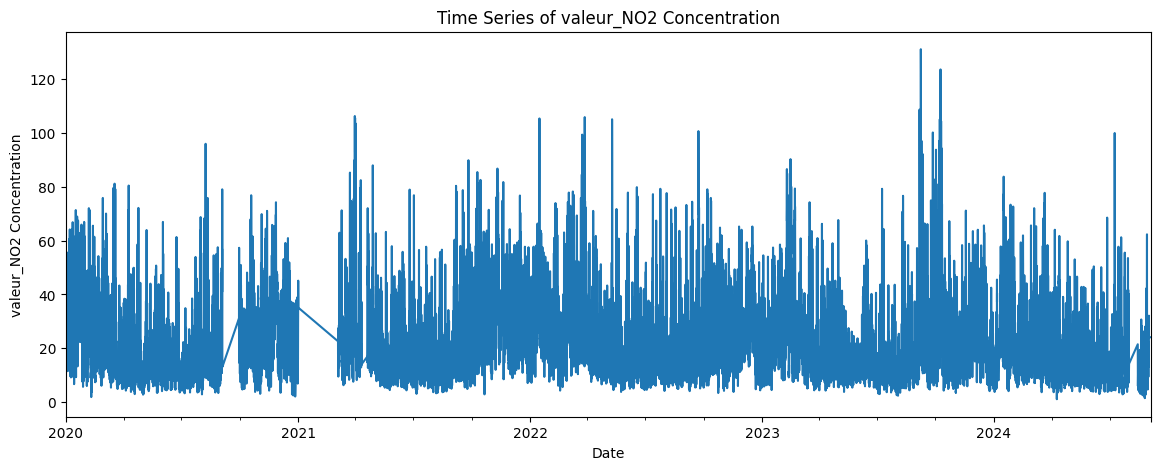

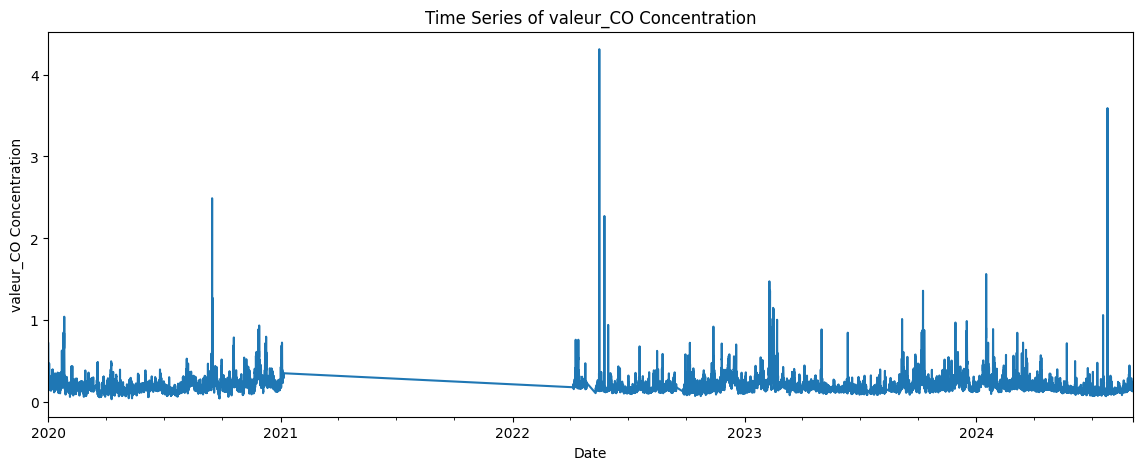

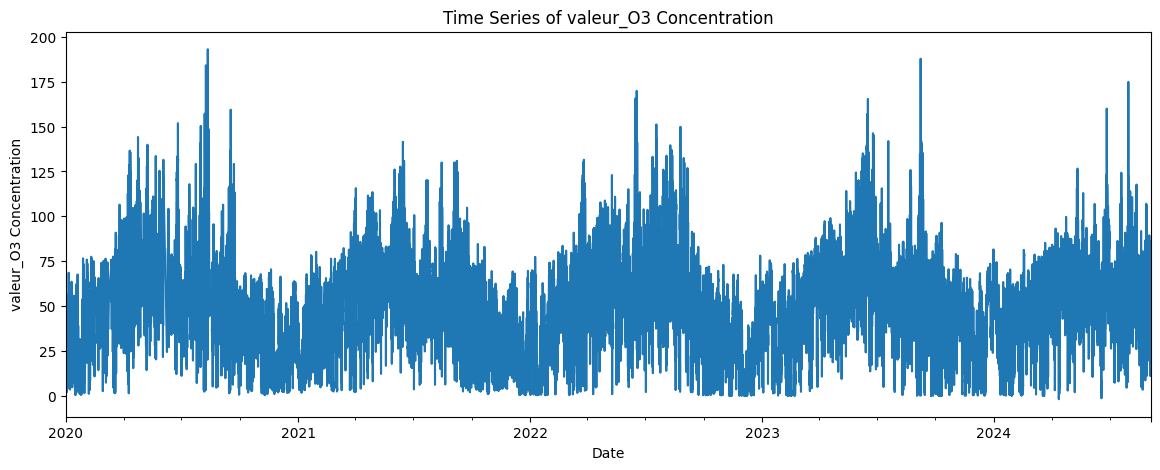

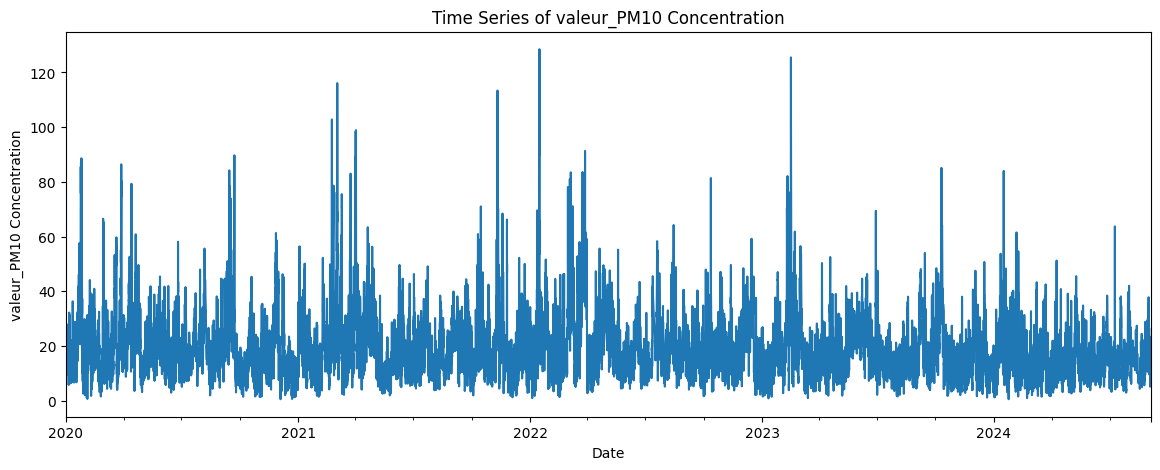

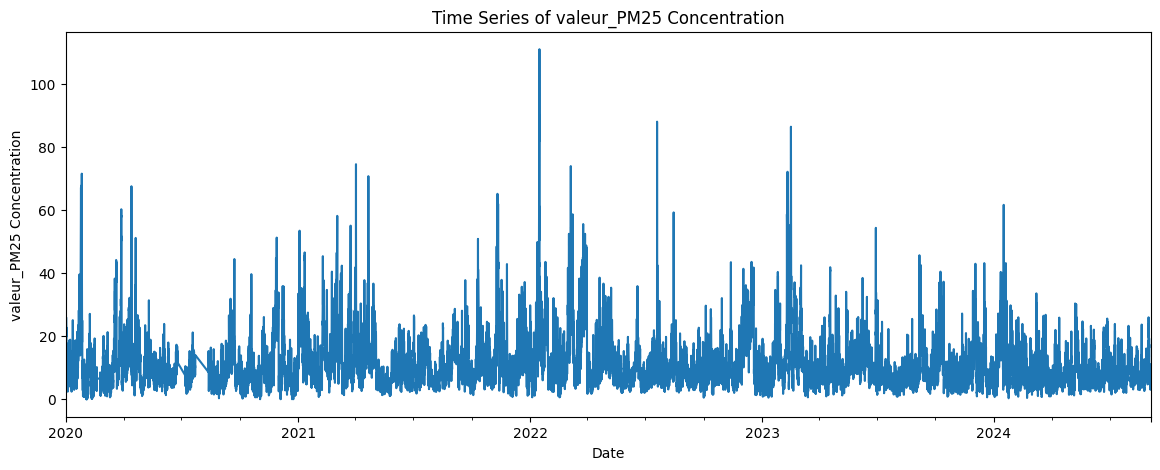

In [7]:
# Plot time series for each pollutant to observe trends and seasonality
for pollutant in pollutants:
    plt.figure(figsize=(14, 5))
    data[pollutant].plot(title=f'Time Series of {pollutant} Concentration')
    plt.xlabel('Date')
    plt.ylabel(f'{pollutant} Concentration')
    plt.show()

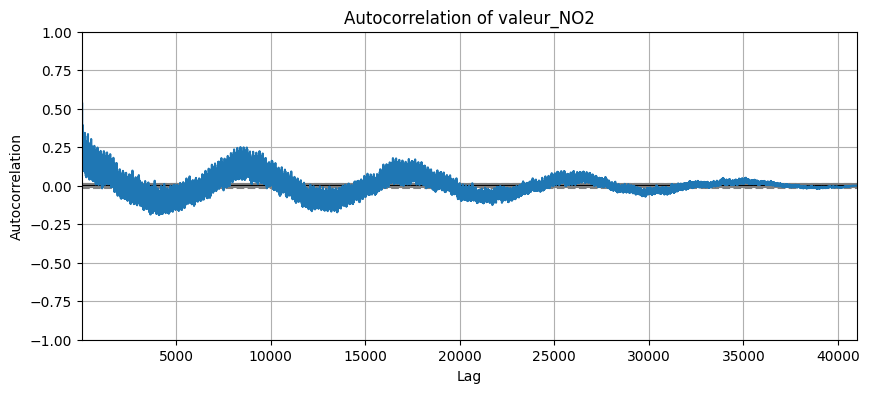

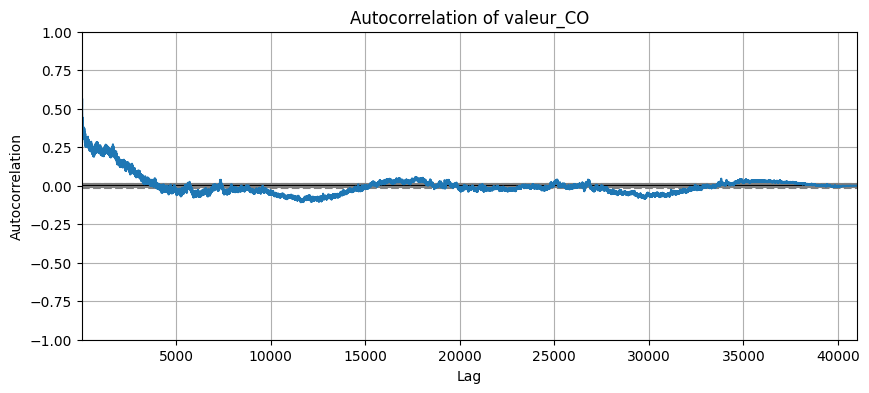

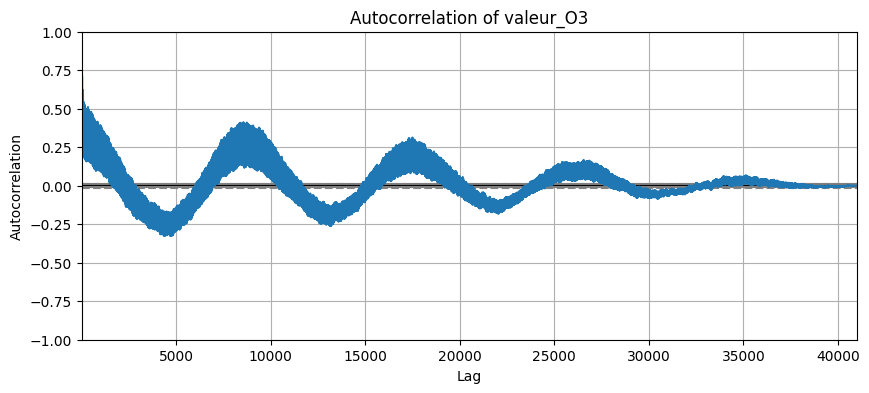

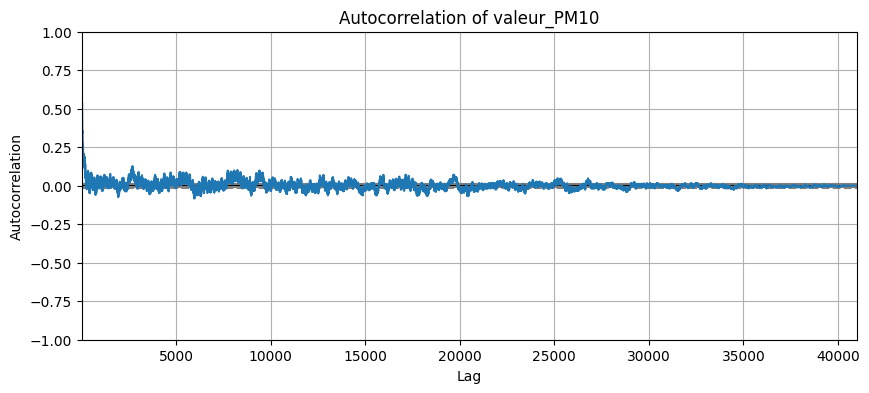

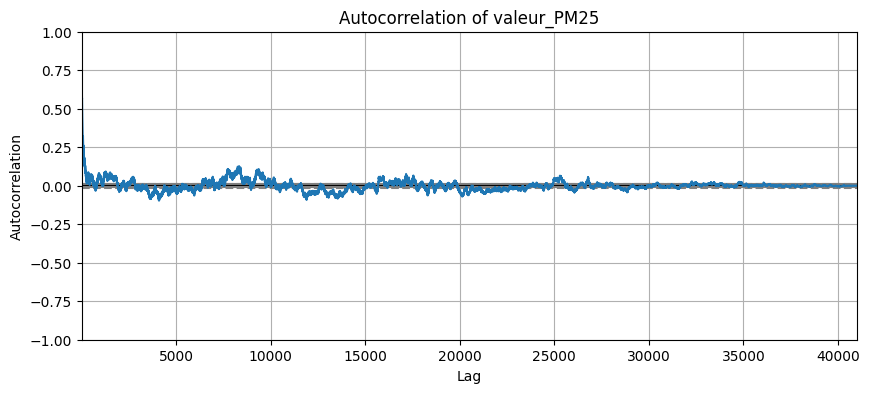

In [8]:
# Autocorrelation for each pollutant (to observe potential seasonality)
for pollutant in pollutants:
    plt.figure(figsize=(10, 4))
    autocorrelation_plot(data[pollutant].dropna())
    plt.title(f'Autocorrelation of {pollutant}')
    plt.show()

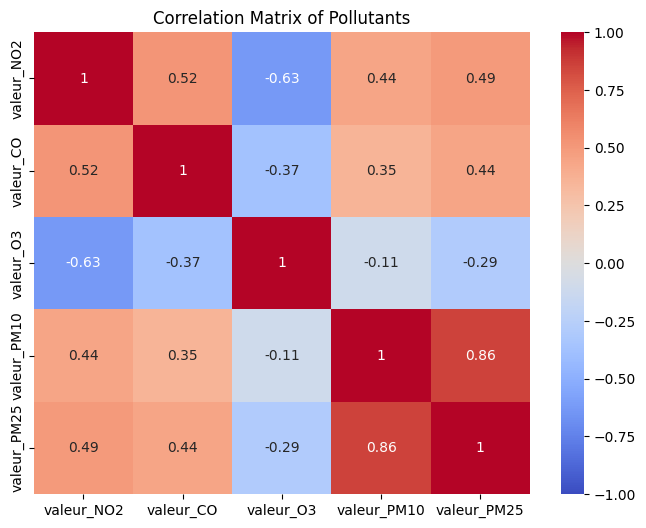

In [9]:
# Check correlations among pollutants
correlation_matrix = data[pollutants].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Pollutants")
plt.show()

<Figure size 1000x800 with 0 Axes>

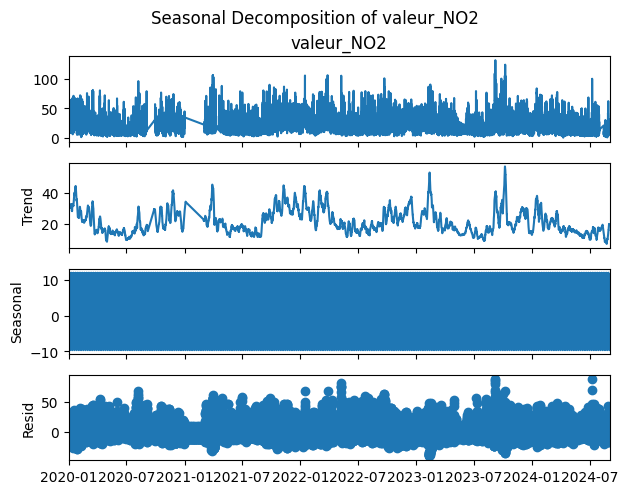

<Figure size 1000x800 with 0 Axes>

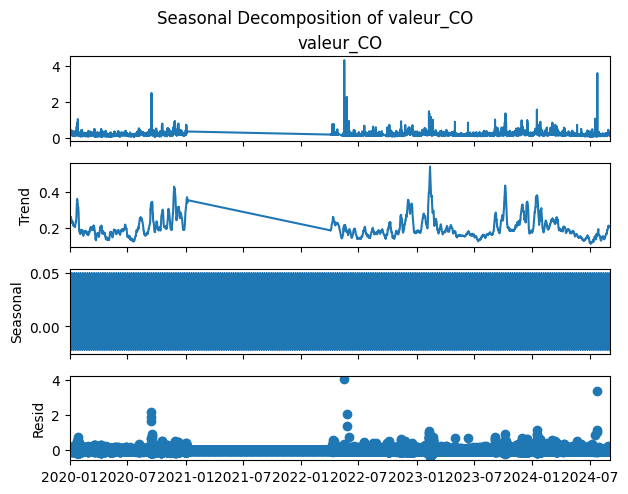

<Figure size 1000x800 with 0 Axes>

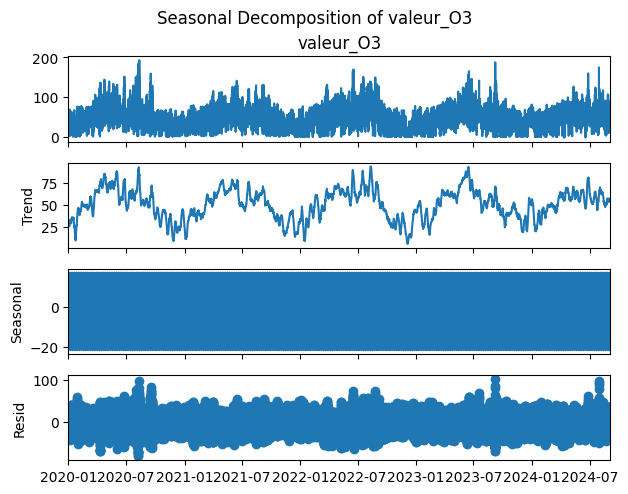

<Figure size 1000x800 with 0 Axes>

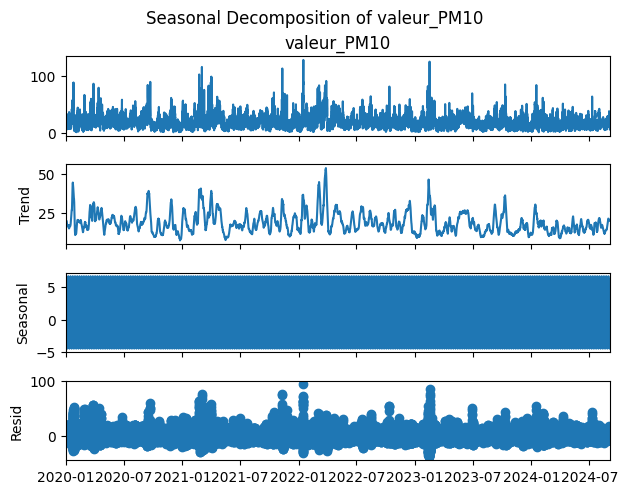

<Figure size 1000x800 with 0 Axes>

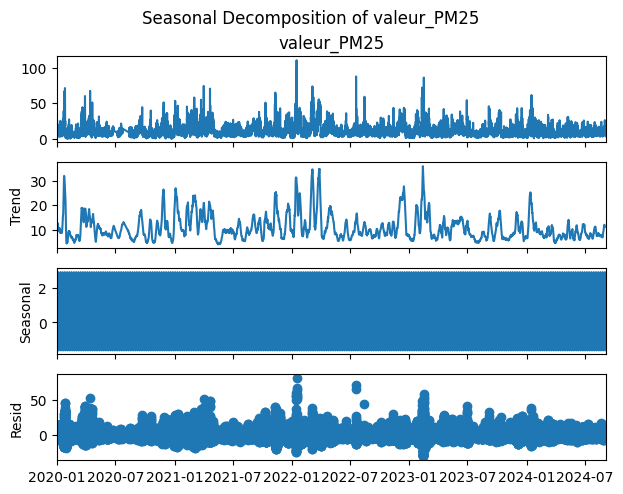

In [10]:
# Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

for pollutant in pollutants:
    plt.figure(figsize=(10, 8))
    decomposition = seasonal_decompose(data[pollutant].dropna(), model='additive', period=24*7)
    decomposition.plot()
    plt.suptitle(f'Seasonal Decomposition of {pollutant}', y=1.02)
    plt.show()

In [11]:
# Fill missing values with forward fill and backward fill
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

# 1. Temporal Features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Add cyclical features for hour, day of the week, and month
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

/var/folders/61/n2sfq6s16zdgx5_xwt6gtdvr0000gn/T/ipykernel_13231/3709031027.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/var/folders/61/n2sfq6s16zdgx5_xwt6gtdvr0000gn/T/ipykernel_13231/3709031027.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [12]:
# 2. Lagged Features (for previous hour, day, and week)
for pollutant in ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']:
    data[f'{pollutant}_lag1'] = data[pollutant].shift(1)  # Previous hour
    data[f'{pollutant}_lag24'] = data[pollutant].shift(24)  # Previous day
    data[f'{pollutant}_lag168'] = data[pollutant].shift(168)  # Previous week

In [13]:
# 3. Rolling Statistics (e.g., mean, std for past day and week)
for pollutant in ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']:
    data[f'{pollutant}_rolling_mean24'] = data[pollutant].rolling(window=24).mean()
    data[f'{pollutant}_rolling_std24'] = data[pollutant].rolling(window=24).std()
    data[f'{pollutant}_rolling_mean168'] = data[pollutant].rolling(window=168).mean()
    data[f'{pollutant}_rolling_std168'] = data[pollutant].rolling(window=168).std()

In [14]:
# 4. Interaction Terms
data['NO2_CO_interaction'] = data['valeur_NO2'] * data['valeur_CO']
data['PM10_PM25_interaction'] = data['valeur_PM10'] * data['valeur_PM25']

# Drop the original temporal columns to avoid redundancy
data.drop(['hour', 'day_of_week', 'month'], axis=1, inplace=True)

# Drop rows with NaN values after creating lagged and rolling features
data.dropna(inplace=True)

# Check the feature-engineered dataset
print(data.head())
print("\nFeature Engineered Data Summary:\n", data.describe())


                     valeur_NO2  valeur_CO  valeur_O3  valeur_PM10  \
id                                                                   
2020-01-08 00:00:00        22.9     0.2530       19.6         13.5   
2020-01-08 01:00:00        15.8     0.2200       33.1         11.7   
2020-01-08 02:00:00        10.2     0.1955       47.3         10.4   
2020-01-08 03:00:00         9.7     0.1710       53.7          7.1   
2020-01-08 04:00:00        11.9     0.1670       52.6          6.3   

                     valeur_PM25  hour_sin  hour_cos  day_of_week_sin  \
id                                                                      
2020-01-08 00:00:00         10.2  0.000000  1.000000         0.974928   
2020-01-08 01:00:00          7.1  0.258819  0.965926         0.974928   
2020-01-08 02:00:00          5.1  0.500000  0.866025         0.974928   
2020-01-08 03:00:00          9.1  0.707107  0.707107         0.974928   
2020-01-08 04:00:00          6.2  0.866025  0.500000         0.974928  

## Save Data to gitignore

In [15]:
data.head()

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,...,valeur_PM10_rolling_mean24,valeur_PM10_rolling_std24,valeur_PM10_rolling_mean168,valeur_PM10_rolling_std168,valeur_PM25_rolling_mean24,valeur_PM25_rolling_std24,valeur_PM25_rolling_mean168,valeur_PM25_rolling_std168,NO2_CO_interaction,PM10_PM25_interaction
id,,,,,,,,,,,,,,,,,,,,,
2020-01-08 00:00:00,22.9,0.2530,19.6,13.5,10.2,0.000000,1.000000,0.974928,-0.222521,0.5,...,19.143750,4.374911,19.170536,7.345376,12.350000,3.456689,12.288095,6.954526,5.7937,137.70
2020-01-08 01:00:00,15.8,0.2200,33.1,11.7,7.1,0.258819,0.965926,0.974928,-0.222521,0.5,...,19.160417,4.344386,18.794940,5.967918,12.262500,3.564781,11.937500,5.579220,3.4760,83.07
2020-01-08 02:00:00,10.2,0.1955,47.3,10.4,5.1,0.500000,0.866025,0.974928,-0.222521,0.5,...,19.052083,4.533006,18.553274,5.456073,12.125000,3.777537,11.700595,4.984480,1.9941,53.04
2020-01-08 03:00:00,9.7,0.1710,53.7,7.1,9.1,0.707107,0.707107,0.974928,-0.222521,0.5,...,18.764583,5.056001,18.430655,5.480705,12.154167,3.750128,11.605357,4.878658,1.6587,64.61
2020-01-08 04:00:00,11.9,0.1670,52.6,6.3,6.2,0.866025,0.500000,0.974928,-0.222521,0.5,...,18.406250,5.615590,18.377083,5.554971,12.091667,3.839035,11.561310,4.893923,1.9873,39.06


In [16]:
# save data to gitignore
# Create a directory if it doesn't exist
import os
if not os.path.exists('data'):
    os.makedirs('data')

# Save the processed dataset
data.to_csv('data/processed_data.csv')

# Add entry to .gitignore if it doesn't exist
gitignore_path = '.gitignore'
gitignore_entry = 'data/processed_data.csv'

# Check if .gitignore exists and create if it doesn't
if not os.path.exists(gitignore_path):
    with open(gitignore_path, 'w') as f:
        f.write(gitignore_entry + '\n')
else:
    # Read existing .gitignore
    with open(gitignore_path, 'r') as f:
        gitignore_content = f.read()

    # Add entry if not already present
    if gitignore_entry not in gitignore_content:
        with open(gitignore_path, 'a') as f:
            f.write('\n' + gitignore_entry + '\n')


In [17]:
test = pd.read_csv('data/test.csv')
test.head()

,id
0,2024-09-03 23
1,2024-09-04 00
2,2024-09-04 01
3,2024-09-04 02
4,2024-09-04 03


In [22]:
test.id.min()

'2024-09-03 23'

In [23]:
test.id.max()

'2024-09-24 22'